In [1]:
%load_ext watermark

In [2]:
%watermark -v -m

Python implementation: CPython
Python version       : 3.7.4
IPython version      : 7.16.1

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 17.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit



First, let's start Ray…

In [3]:
import logging
import ray

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)

print(f"Dashboard URL: http://{ray.get_dashboard_url()}")

File descriptor limit 256 is too low for production servers and may result in connection errors. At least 8192 is recommended. --- Fix with 'ulimit -n 8192'


Dashboard URL: http://127.0.0.1:8265


In [4]:
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import time

In [5]:
def estimate_pi (num_samples):
    xs = np.random.uniform(low=-1.0, high=1.0, size=num_samples)   # generate num_samples random samples for the x coordinate
    ys = np.random.uniform(low=-1.0, high=1.0, size=num_samples)   # generate num_samples random samples for the y coordinate
    xys = np.stack((xs, ys), axis=-1)                              # similar to Python's "zip(a,b)"; creates np.array([(x1,y1), (x2,y2), ...]).

    inside = (xs**2.0 + ys**2.0) <= 1.0                            # create a predicate over all the array elements
    xys_inside = xys[inside]                                       # select only those  elements inside the circle
    in_circle = xys_inside.shape[0]                                # return the number of elements inside the circle
    approx_pi = 4.0 * in_circle / num_samples                      # the Pi estimate

    return approx_pi

In [6]:
@ray.remote
def distrib_estimate_pi (num_samples):
    return estimate_pi(num_samples)

In [7]:
def measure_epoch (n, trials=20, distrib=False):
    start = time.time()
    
    if distrib:
        refs = [distrib_estimate_pi.remote(n) for _ in range(trials)]
        pis = ray.get(refs)
    else:
        pis = [estimate_pi(n) for _ in range(trials)]

    duration = time.time() - start
    approx_pi = statistics.mean(pis)
    stdev = statistics.stdev(pis)
    error = 100.0 * abs(approx_pi - np.pi) / np.pi

    return n, duration, approx_pi, stdev, error

In [8]:
class Sim:
    _DF_COL_NAMES = ["n", "duration", "approx_pi", "stdev", "error"]
    MAX_N = 1000000

    def __init__ (self, distrib=False, max_n=MAX_N, step=int(MAX_N/20)):
        self.distrib = distrib
        self.max_n = max_n
        self.step = step
        self.df = None


    def run (self):
        results = [
            measure_epoch(n, distrib=self.distrib)
            for n in range(2, self.max_n, self.step)
        ]
    
        self.df = pd.DataFrame(results, columns=self._DF_COL_NAMES)
        return self


    def plot (self):
        plt.plot("n", "error", data=self.df, color="red", linewidth=0.5, linestyle="dashed")
        plt.plot("n", "stdev", data=self.df, color="blue", linewidth=2)
        plt.plot("n", "duration", data=self.df, color="green", linewidth=1, linestyle="dashed")

        plt.yscale("log")
        plt.legend()
        plt.show()

        return self

Profiling tools:

  * [objgraph](https://mg.pov.lt/objgraph/)
  * [tracemalloc](https://docs.python.org/3/library/tracemalloc.html)
  * [Pyinstrument](https://github.com/joerick/pyinstrument/)
  * [prun](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-prun)
  * [SnakeViz](https://jiffyclub.github.io/snakeviz/)

In [9]:
import objgraph
import tracemalloc
import pyinstrument

%load_ext snakeviz

In [10]:
objgraph.show_growth(limit=10)

function              34457    +34457
dict                  20773    +20773
tuple                 16643    +16643
list                   8743     +8743
cell                   6437     +6437
weakref                6134     +6134
getset_descriptor      4590     +4590
type                   3693     +3693
method_descriptor      3464     +3464
wrapper_descriptor     3232     +3232


In [11]:
%%time

sim_s = Sim(distrib=False, max_n=Sim.MAX_N)
sim_s.run();

CPU times: user 8.88 s, sys: 2.14 s, total: 11 s
Wall time: 11.4 s


In [12]:
objgraph.show_growth()

function                      34504       +47
dict                          20805       +32
tuple                         16673       +30
Context                          57       +18
member_descriptor               899       +16
weakref                        6145       +11
Handle                           38       +11
builtin_function_or_method     3161        +9
getset_descriptor              4599        +9
method                          419        +7


In [13]:
objgraph.show_most_common_types() 

function           34557
dict               20814
tuple              16731
list               8747
cell               6717
weakref            6145
getset_descriptor  4599
type               3700
method_descriptor  3464
wrapper_descriptor 3232


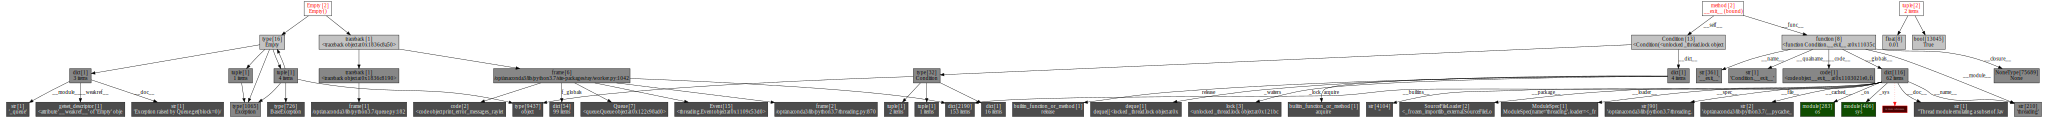

In [14]:
roots = objgraph.get_leaking_objects()
objgraph.show_refs(roots[:3], refcounts=True)

In [15]:
tracemalloc.start()

Sim(distrib=False, max_n=Sim.MAX_N).run()

snapshot = tracemalloc.take_snapshot()

In [16]:
top_stats = snapshot.statistics('traceback')

# pick the biggest memory block
for stat in top_stats:
    print("%s memory blocks: %.1f KiB" % (stat.count, stat.size / 1024))

    for line in stat.traceback.format():
        print(line)

5 memory blocks: 2.7 KiB
  File "/opt/anaconda3/lib/python3.7/site-packages/redis/connection.py", line 417
    raise_on_timeout=False)
19 memory blocks: 1.7 KiB
  File "<__array_function__ internals>", line 6
3 memory blocks: 1.3 KiB
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/core/internals/construction.py", line 728
    arr = lib.maybe_convert_objects(arr, try_float=coerce_float)
40 memory blocks: 0.9 KiB
  File "/opt/anaconda3/lib/python3.7/statistics.py", line 535
    T, total, count = _sum((x-c)**2 for x in data)
10 memory blocks: 0.8 KiB
  File "/opt/anaconda3/lib/python3.7/threading.py", line 289
    waiter = _allocate_lock()
2 memory blocks: 0.7 KiB
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 404
    new_data, dtype=new_dtype, copy=False, name=name, **kwargs
1 memory blocks: 0.6 KiB
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 1872
    stacked = np.empty(shape, dtype=dtype)
20

In [17]:
%%prun -q -T prof_cpu.txt
%%snakeviz

Sim(distrib=False, max_n=Sim.MAX_N).run()

 
*** Profile stats marshalled to file '/var/folders/zz/2ffrqd5j7n52x67qd94h_r_h0000gp/T/tmpn9epu7ou'. 
Embedding SnakeViz in this document...


 
*** Profile printout saved to text file 'prof_cpu.txt'. 



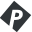

In [18]:
profiler = pyinstrument.Profiler()
profiler.start()

Sim(distrib=False, max_n=Sim.MAX_N).run()

profiler.stop()
display(HTML(profiler.output_html()))

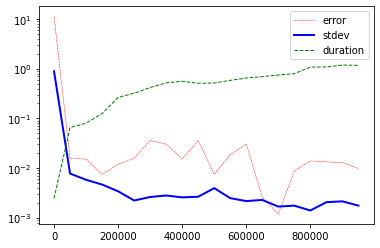

In [19]:
sim_s.plot();

In [20]:
sim_s.df.describe()

,n,duration,approx_pi,stdev,error
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,475002.000000,0.569075,3.159568,0.047233,0.585550
std,295803.989155,0.368149,0.080131,0.198025,2.547468
min,2.000000,0.002455,3.140456,0.001399,0.001194
25%,237502.000000,0.307023,3.141212,0.002119,0.009529
50%,475002.000000,0.540362,3.141571,0.002524,0.014551
75%,712502.000000,0.759940,3.142110,0.003543,0.021527
max,950002.000000,1.188916,3.500000,0.888523,11.408460


In [21]:
%%time

sim_d = Sim(distrib=True, max_n=Sim.MAX_N)
sim_d.run();

CPU times: user 333 ms, sys: 82.5 ms, total: 415 ms
Wall time: 6.01 s


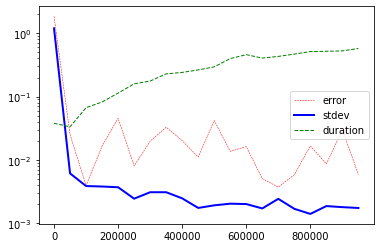

In [22]:
sim_d.plot();

In [23]:
sim_d.df.describe()

,n,duration,approx_pi,stdev,error
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,475002.000000,0.299923,3.144439,0.062267,0.109475
std,295803.989155,0.182905,0.013095,0.266970,0.412017
min,2.000000,0.033273,3.140280,0.001401,0.003713
25%,237502.000000,0.147649,3.141056,0.001780,0.007494
50%,475002.000000,0.279348,3.141589,0.002228,0.016381
75%,712502.000000,0.462208,3.142044,0.003238,0.026317
max,950002.000000,0.575365,3.200000,1.196486,1.859164


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

degree = 1
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

X = sim_s.df.iloc[:, 0].values.reshape(-1, 1)
Y_s = sim_s.df.iloc[:, 1].values.reshape(-1, 1)
Y_d = sim_d.df.iloc[:, 1].values.reshape(-1, 1)

polyreg.fit(X, Y_s)
Y_s_pred = polyreg.predict(X)

polyreg.fit(X, Y_d)
Y_d_pred = polyreg.predict(X)

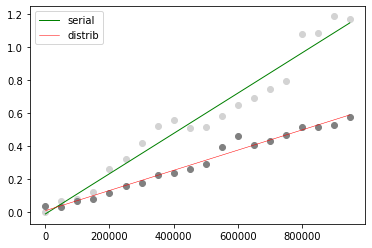

In [25]:
plt.scatter(X, Y_s, color="lightgray")
plt.scatter(X, Y_d, color="gray")

plt.plot(X, Y_s_pred, color="green", linewidth=1, label="serial")
plt.plot(X, Y_d_pred, color="red", linewidth=0.5, label="distrib")

plt.legend()
plt.show()

In [26]:
m = (Y_s_pred / Y_d_pred)
m

array([[-1.08182743],
       [ 1.26345318],
       [ 1.57997195],
       [ 1.70535801],
       [ 1.7725877 ],
       [ 1.81450515],
       [ 1.84314084],
       [ 1.86394405],
       [ 1.87974169],
       [ 1.89214638],
       [ 1.9021452 ],
       [ 1.9103762 ],
       [ 1.91727013],
       [ 1.92312832],
       [ 1.92816787],
       [ 1.93254918],
       [ 1.93639329],
       [ 1.93979331],
       [ 1.94282199],
       [ 1.94553701]])

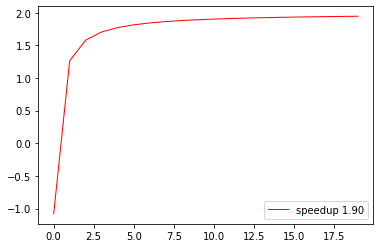

In [27]:
plt.plot(m, color="red", linewidth=1, label="speedup {:.2f}".format(np.median(m)))
plt.legend()
plt.show()

Finally, shutdown Ray

In [28]:
ray.shutdown()